# Time Series Analysis

## <u>Exploratory Analysis </u>

Do your work for this exercise in a notebook named explore. Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

In [1]:
# Import libraries

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import statsmodels.api as sm
import prepare 
import acquire

import datetime

# plotting defaults
plt.rc('figure', figsize = (13, 6))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size = 16)


### Acquire Data

> ## (i) Store, Item, Demand Data

In [2]:
df = prepare.prepare_store_data()
df.head(2)

,item_id,sale_amount,sale_id,store_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14,month,day,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,1,1,10.92
2013-01-01,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,1,218.40


In [3]:
# Get max and min dates

print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00


### Split Data (Human- based method)

In [4]:
# Train set is all data till end of 2016, test data is 2017 data

train = df[:'2016']
test = df['2017']

### Exploratory Data Analysis

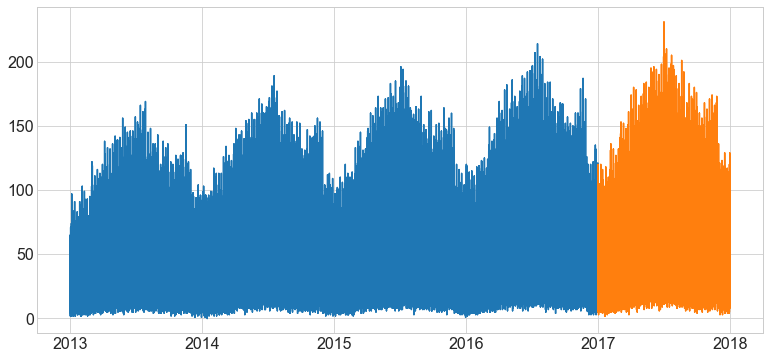

In [5]:
# Sales amount in train and test set

plt.plot(train.index, train.sale_amount)
plt.plot(test.index, test.sale_amount)

### Visualizations

(target == sale_amount)


In [6]:
# sales amount(y) == target

y = train.sale_amount
y.head()

sale_date
2013-01-01    13.0
2013-01-01    26.0
2013-01-01    27.0
2013-01-01    54.0
2013-01-01    35.0
Name: sale_amount, dtype: float64

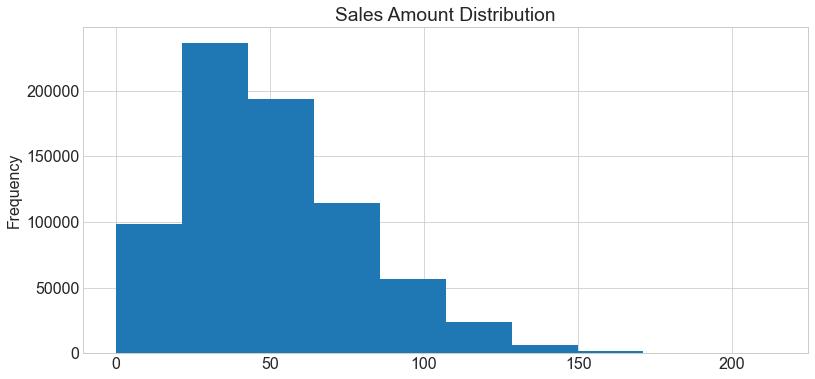

In [7]:
# Target distribution

y.plot.hist()
plt.title('Sales Amount Distribution')
None

[Text(0.5, 1.0, 'Average sale_amount by month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Sale Amount (USD)')]

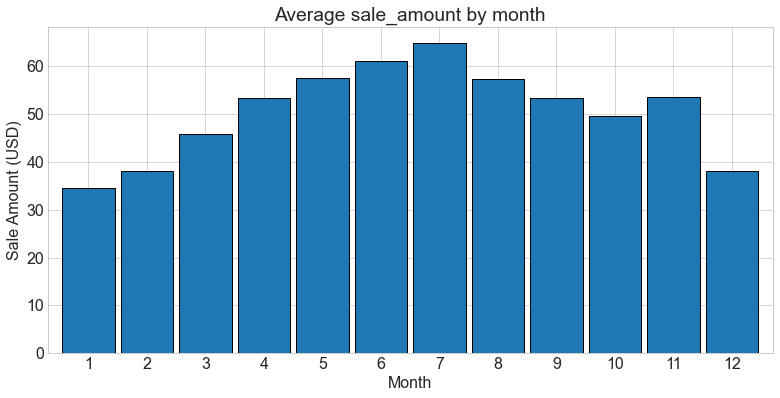

In [8]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average sale_amount by month', xlabel='Month', ylabel='Sale Amount (USD)')


[Text(0.5, 1.0, 'Average Sales Amount by Weekday'),
 Text(0.5, 22.200000000000003, 'Weekday'),
 Text(22.278125000000003, 0.5, 'Sales Amount (USD)')]

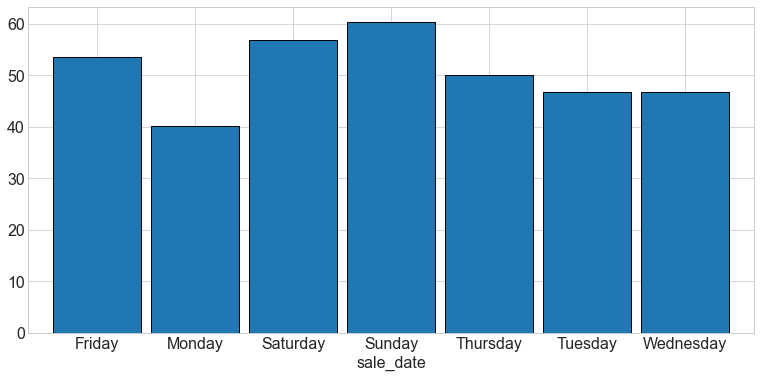

In [9]:
# Target over time

y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales Amount by Weekday', xlabel='Weekday', ylabel='Sales Amount (USD)')


### Using resample to visualize sales amount over a time period

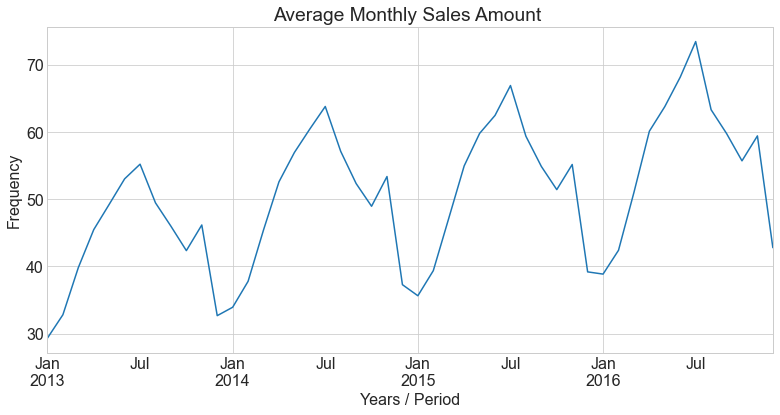

In [10]:
y.resample('M').mean().plot(title='Average Monthly Sales Amount ')
plt.xlabel('Years / Period')
plt.ylabel('Frequency')
plt.show()

### Seasonal Plot

##### Shows the comparison of multiple years together

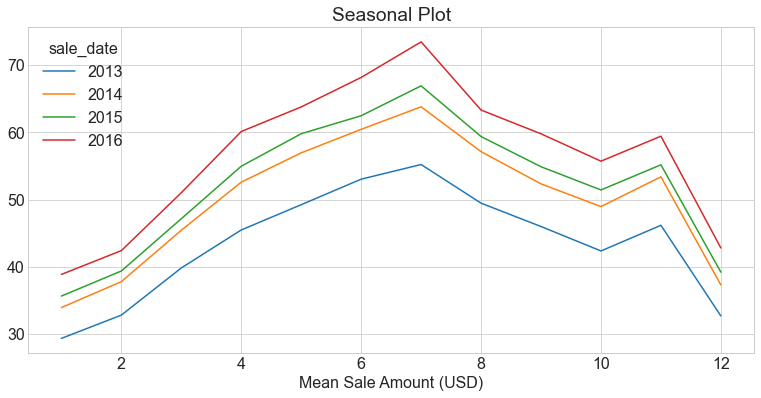

In [11]:
# .unstack turns an index level into columns

y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title = 'Seasonal Plot')
plt.xlabel('Mean Sale Amount (USD)')
plt.show()

### Lag Plot

##### Lag plot measures one value against the next / previous value
NOTE:
- If your data is sampled daily, you could think of t as 'today', t+1 is 'tomorrow'. 
- In reality, t is any given time period and t+1 is the time period after. 
- If your data is sampled weekly,  t is any given week, and t+1 is the following week

In [12]:
train.store_zipcode

sale_date
2013-01-01    78253
2013-01-01    78217
2013-01-01    78217
2013-01-01    78232
2013-01-01    78221
              ...  
2016-12-31    78220
2016-12-31    78253
2016-12-31    78204
2016-12-31    78221
2016-12-31    78201
Name: store_zipcode, Length: 730500, dtype: int64

,item_id,this_quarter_sales,sale_id,store_id,store_zipcode,item_price,item_upc12,item_upc14,month,day,sales_total,next_quarter_sales
sale_date,,,,,,,,,,,,
2013-01-31,25.5,29.348645,455603.0,5.5,78224.8,5.1604,2.384688e+11,2.384688e+11,1.000000,1.000000,157.894723,39.529730
2013-04-30,25.5,39.529730,455663.0,5.5,78224.8,5.1604,2.384688e+11,2.384688e+11,3.022472,3.022472,212.505231,52.494804


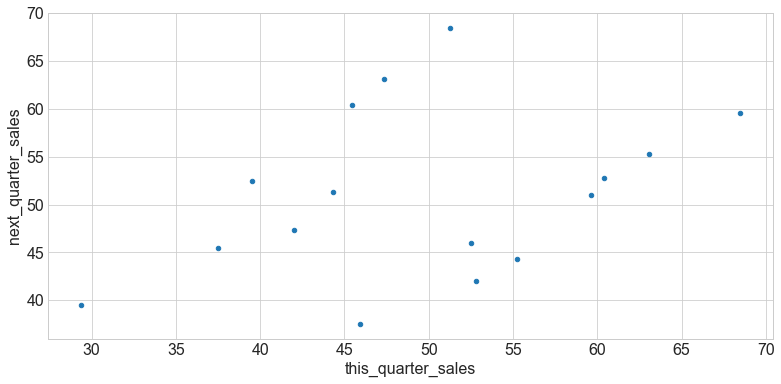

In [13]:
# Create next quater (3 Months) sale amount columns(y resampled by month)

quarterly = train.resample('3M').mean()
quarterly['next_quarter_sales'] = quarterly.sale_amount.shift(-1)
quarterly = quarterly.rename(columns={'sale_amount': 'this_quarter_sales'})
quarterly.plot.scatter(x='this_quarter_sales', y='next_quarter_sales')
quarterly.head(2)


### Autocorrelation Plot

- Measure of the linear relationship between lagged values of a time series.
- An autocorrelation plot shows the correlation coefficient as a function of lag time.

- The __peaks__ can tells us the frequency with which the seasonality repeats itself, and the __valleys__ show us where the correlation is the most negative.

The __dashed lines__ are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

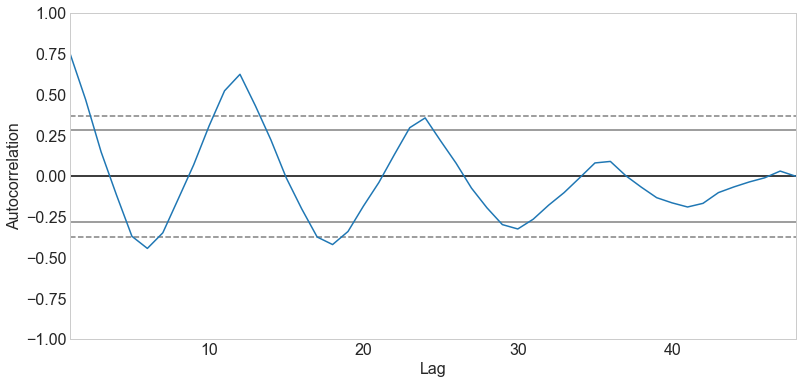

In [14]:
pd.plotting.autocorrelation_plot(train.sale_amount.resample('M').mean())

> ## (ii) Store, Item, Demand Data

>- ####  Target == Consumption

### Acquire Data

In [15]:
ops_df = prepare.prepare_ops_data()
ops_df.head()

,consumption,wind,solar,wind_solar,month,year,day
date,,,,,,,
2006-01-01,1069.184,NaN,NaN,NaN,1,2006,1
2006-01-02,1380.521,NaN,NaN,NaN,1,2006,1
2006-01-03,1442.533,NaN,NaN,NaN,1,2006,1
2006-01-04,1457.217,NaN,NaN,NaN,1,2006,1
2006-01-05,1477.131,NaN,NaN,NaN,1,2006,1


In [16]:
# Get max and min dates

print('Date Range:', ops_df.index.min(), 'to', ops_df.index.max())

Date Range: 2006-01-01 00:00:00 to 2017-12-31 00:00:00


### Split the Data (Percentage Method)

In [17]:
# train_size = .70
# n = ops_df.shape[0]
# test_start_index = round(train_size * n)

# train_ops = ops_df[:test_start_index] # everything up (not including) to the test_start_index
# test_ops = ops_df[test_start_index:] # everything from the test_start_index to the end

# plt.plot(train_ops.index, train.sale_amount)
# plt.plot(test_ops.index, test.sale_amount)

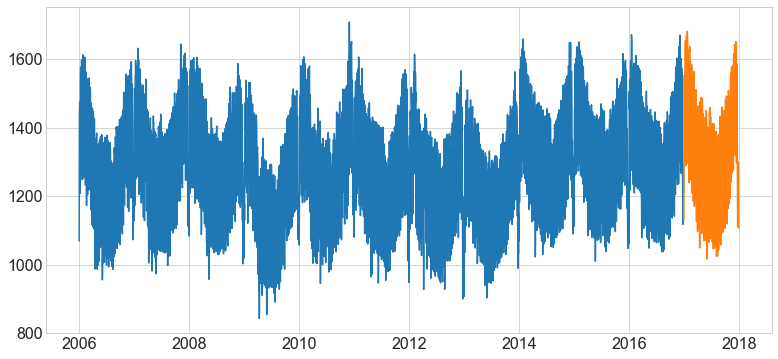

In [35]:
# Human-Based Method Splitting

train = ops_df.loc[:'2016'] # includes 2016
test = ops_df.loc['2017']

plt.plot(train.index, train.consumption)
plt.plot(test.index, test.consumption)

In [37]:
# Check the dates index

train.index

# # Set each date as day, (correct for 'freq = None') and fill NaN columns
# # (ffill refers to forward fill. This means when a null is encountered for a particular column, 
# #it will be replaced by the value in the previous row)
# train = train.asfreq('D', method = 'ffill')

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=4018, freq=None)

## Create target variable Y

In [19]:
y = train.consumption
y.head()

date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: consumption, dtype: float64

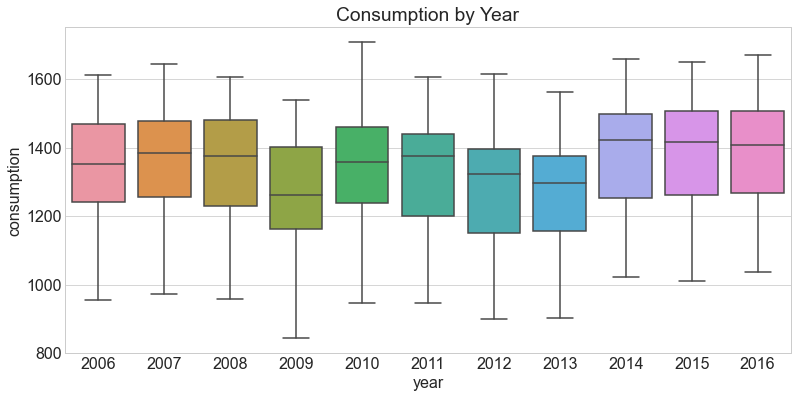

In [20]:
# Consumption by Year

sns.boxplot(data = train, y = y, x='year')
plt.title('Consumption by Year')
plt.show()

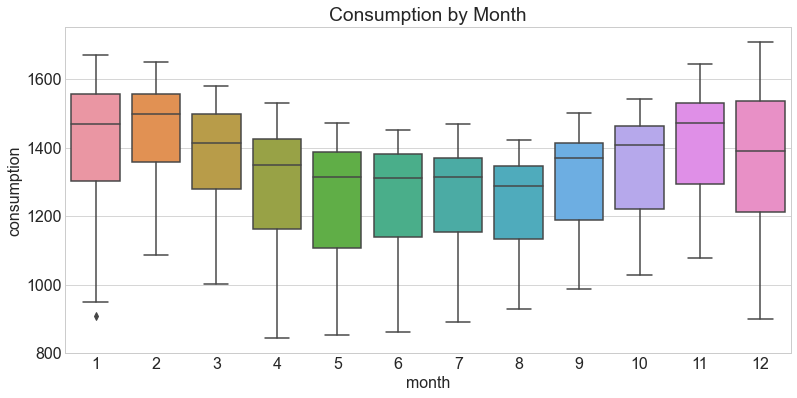

In [21]:
# Consumption by Year

sns.boxplot(data=train, y = y, x='month')
plt.title('Consumption by Month')
plt.show()

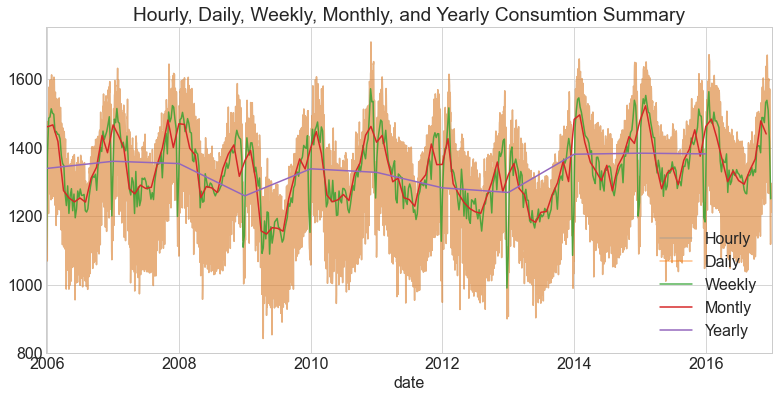

In [22]:
# Hourly, Daily, Weekly, Monthly, and Yearly Summary

y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.title('Hourly, Daily, Weekly, Monthly, and Yearly Consumtion Summary')
plt.legend()
plt.show()

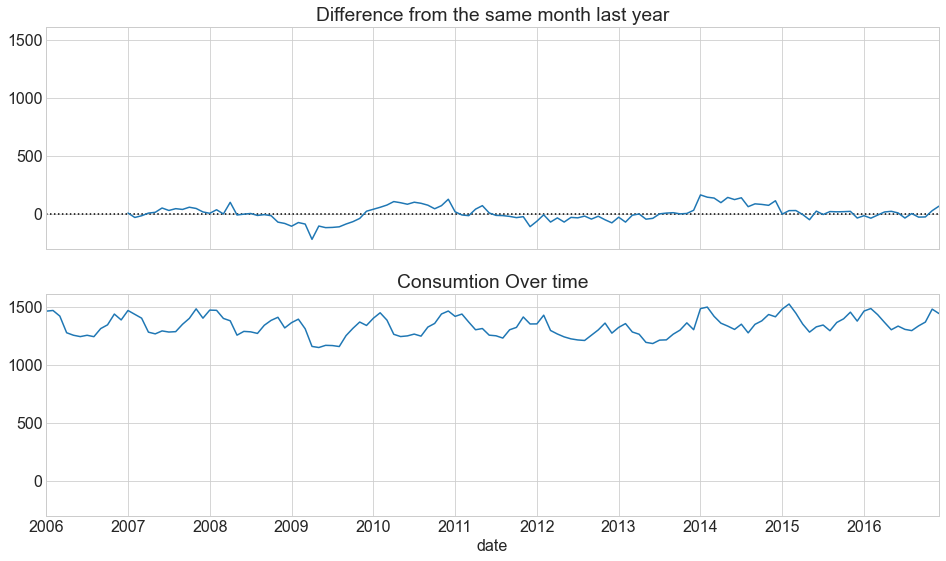

In [23]:
# Compare months difference by last years data

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize=(16, 9))

ax = y.resample('M').mean().diff(12).plot(ax = ax1)
ax1.hlines(0, *ax1.get_xlim(), color = 'black', ls = ':')
ax1.set(title='Difference from the same month last year')

y.resample('M').mean().plot(ax = ax2)
ax2.set(title='Consumtion Over time')
plt.show()

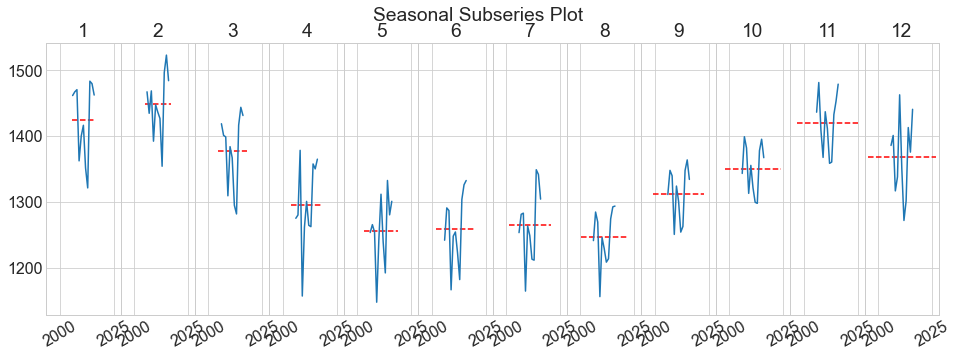

In [24]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey = True, sharex = True, figsize = (16, 5))

for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax = ax, title = month)
    ax.hlines(subset.mean(), *ax.get_xlim(), color = 'red', ls='--')
    ax.set(xlabel ='')
    ax.tick_params('x', rotation=30)
    
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
# fig.tight_layout()
fig.subplots_adjust(wspace = 0)

### Seasonal Decompoasition
- Fancy way to say that we can model time series as having 3 seperate components, the seasonal repeated cycle, the long term trend, and random noise 1. There are two types of seasonal decomposition models:
    - Additive y (t = St + Tt + Rt)
    - Multiplicative (yt = St × Tt × Rt)
    
- __Trend__ is the smooth long term tendency of a time series . It might change direction (increase or decrease) as time progresses.
    
   
"random noise" is a slightly innacurate way to describe this component. Technically this component is the residual, or the error in our prediction. Similar to when we are examining linear regression models, any pattern observed in the residuals of our model tell us that the model failed to capture that pattern.

In [25]:
y = train.consumption.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
date,,,,
2006-01-01,1069.184000,NaN,-33.536583,NaN
2006-01-08,1381.300143,NaN,-151.128130,NaN
2006-01-15,1486.730286,NaN,-23.125938,NaN
2006-01-22,1490.031143,NaN,97.415793,NaN
2006-01-29,1514.176857,NaN,125.755815,NaN


<AxesSubplot:xlabel='date'>

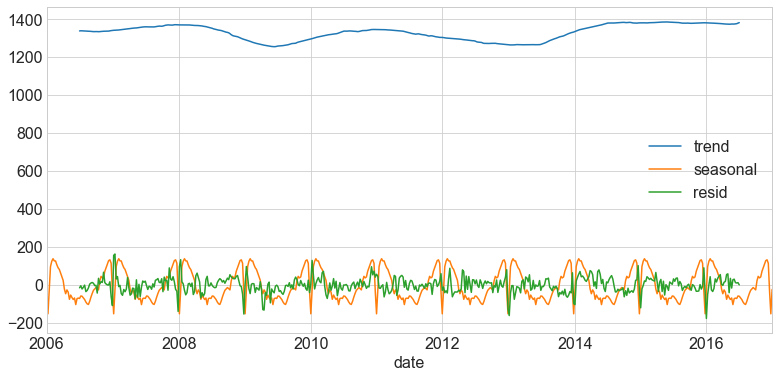

In [26]:
decomposition.iloc[:, 1:].plot()

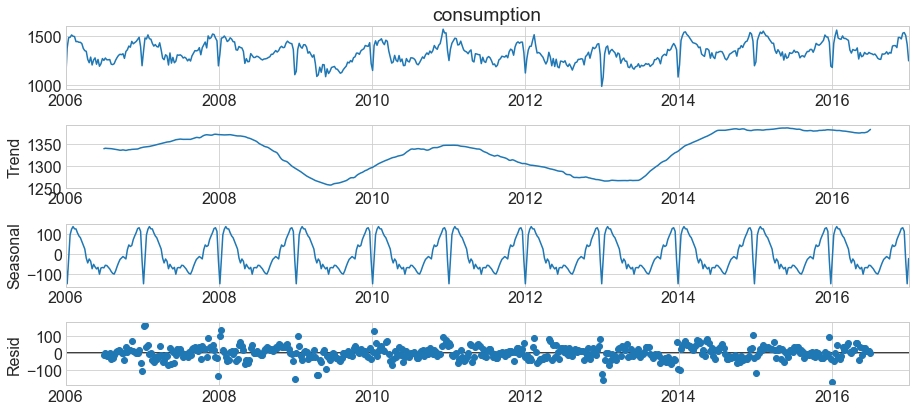

In [27]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


In [28]:
result.plot_diagnostics()

AttributeError: 'DecomposeResult' object has no attribute 'plot_diagnostics'

### Categories Over Time 

In [ ]:
train = train.resample('D').mean()
# create a categorical feature
train['consumption_bin'] = pd.qcut(train.consumption, 3, labels=['Low', 'Medium', 'High'])
train.groupby('consumption_bin').mean()


In [ ]:
# (train.groupby('consumption_bin').resample('M').size().unstack(0)
#  .apply(lambda row: row / row.sum(), axis = 1).plot.area())

# plt.ylabel('% of days in the month')

In [29]:
# ax = (train['2015']
#  .groupby('consumption_bin')
#  .resample('M')
#  .size()
#  .unstack(0)
#  .plot.bar(stacked = True, width = .9, ec = 'black')
# )
# labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]

# ax.set_xticklabels(labels)


### Strftime

- Logically ordering days of  weeks. E.g. 0 == Sunday, 1 == Monday etc

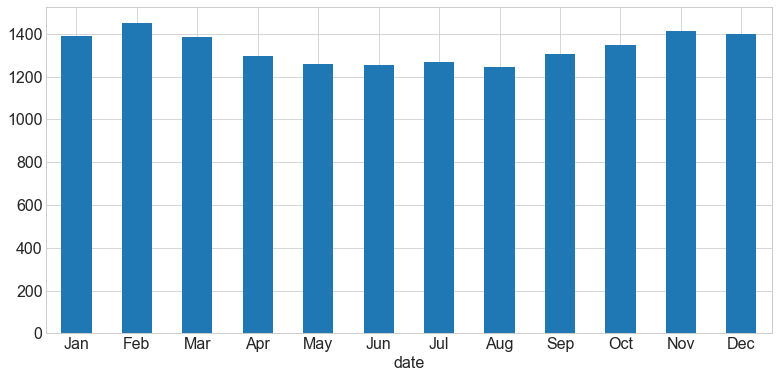

In [30]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

### Using Matplotlib Dates

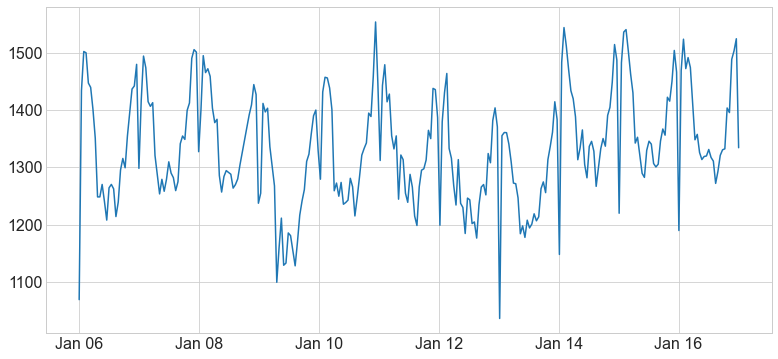

In [31]:
# Bi-weekly mean consumption

from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

biweekly = y.resample('2W').mean()

ax.plot(biweekly.index, biweekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))


### Rolling Average

<AxesSubplot:xlabel='date'>

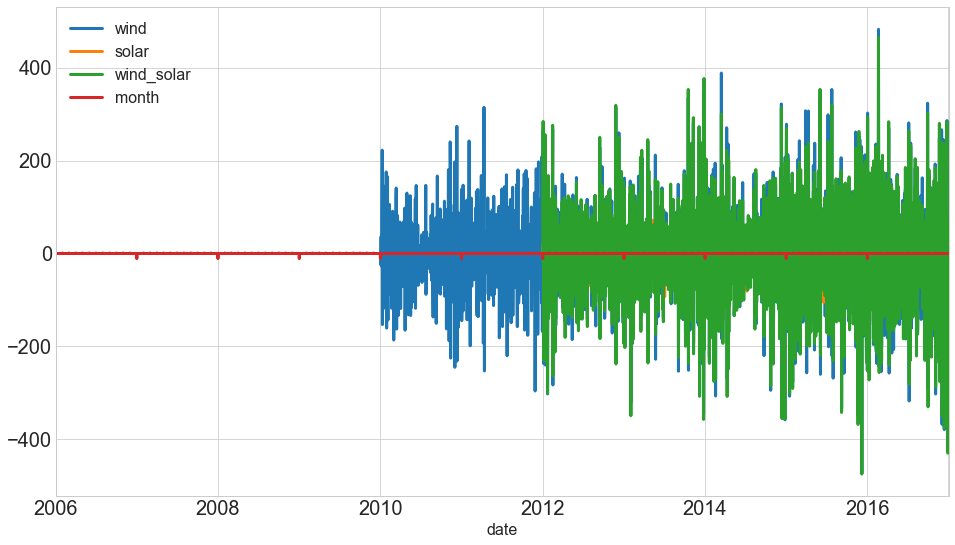

In [32]:
train[['wind', 'solar', 'wind_solar','month']].diff().plot(figsize = (16, 9), linewidth = 3, fontsize = 20)


In [33]:
train.diff().corr()

,consumption,wind,solar,wind_solar,month,year,day
consumption,1.000000,-0.017098,0.003048,-0.025017,0.012137,-0.023218,0.012137
wind,-0.017098,1.000000,-0.108280,0.962062,-0.002803,0.006076,-0.002803
solar,0.003048,-0.108280,1.000000,0.167053,0.005270,-0.004962,0.005270
wind_solar,-0.025017,0.962062,0.167053,1.000000,0.028253,-0.025571,0.028253
month,0.012137,-0.002803,0.005270,0.028253,1.000000,-0.954900,1.000000
year,-0.023218,0.006076,-0.004962,-0.025571,-0.954900,1.000000,-0.954900
day,0.012137,-0.002803,0.005270,0.028253,1.000000,-0.954900,1.000000


In [247]:
train.columns

Index(['consumption', 'wind', 'solar', 'wind_solar', 'month', 'year', 'day'], dtype='object')

In [248]:
cols = ['consumption', 'wind', 'solar', 'wind_solar', 'month', 'year', 'day']

In [262]:
# Seven day rolling 

seven_day_rol = train[cols].rolling(window = 7, center = True).mean()
seven_day_rol

,consumption,wind,solar,wind_solar,month,year,day
date,,,,,,,
2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN,1.0,2006.0,1.0
2006-01-05,1381.300143,NaN,NaN,NaN,1.0,2006.0,1.0
...,...,...,...,...,...,...,...
2016-12-27,1229.340857,483.183857,24.181143,507.365000,12.0,2016.0,12.0
2016-12-28,1231.800000,430.834429,27.286429,458.120857,12.0,2016.0,12.0
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
